In [1]:
import numpy as np
import random as random
import pandas as pd
import matplotlib.pyplot as plt

from sudoku import Sudoku
from sudoku import Solver

# numbers dataset
from keras.datasets import mnist

from tensorflow.keras import backend as K
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# import of .png
import matplotlib.image as mpimg

import cv2

import os

Using TensorFlow backend.


#### To Do:
- comment and document code better
- Improve training set with 
    - more fonts
    - write function to center all the numbers in square arrays
    - translation of numbers
    - padding of numbers / zooming in
    - added noise
- improve edge detection
    - edgecase where border is close to edge of picture
    - or by using cv2.HoughLinesP
    - if edges != to 20 increase or decrease noise threshold and try again
- add functionality to detect degree of rotation of sudoku
- write CNN and train it
- if CNN unsure (below threshold) square is left empty (0)
- create proper solvable sudoku png to validate method

In [2]:
# # importing mnist digits dataset
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# # replace zeros by empty cell
# x_train[y_train[:] == 0] = np.zeros([28,28])
# x_test[y_test[:] == 0] = np.zeros([28,28])

# # rescaling from RGB Values to between 0-1
# x_train = x_train/255
# x_test = x_test/255

In [26]:
def fill_squares(grid, square_size, grid_thickness, square_grid_thickness, mode, data, noise):  
    for i in np.arange(9):
        pos_i = i*square_size + (i-int(i/3))*grid_thickness  + int(i/3)*square_grid_thickness
        for j in np.arange(9):
            pos_j = j*square_size + (j-int(j/3))*grid_thickness  + int(j/3)*square_grid_thickness
            
            if mode == "noise":
                grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size] = np.random.normal(noise[0],noise[1],[square_size,square_size])

            elif mode == "numbers":
                digits, labels = data
                rand_num = digits[np.random.randint(digits.shape[0])]
                rand_num = cv2.resize(rand_num, (square_size,square_size), interpolation = cv2.INTER_AREA)
                
                if np.random.rand() > 0.5:
                    grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size] = rand_num
                else:
                    grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size] = np.ones([square_size,square_size])

            elif mode == "sudoku":
                digits, labels = data
                sudoku = Sudoku()
                sudoku.download_new()
                num_indices = np.argwhere(labels == sudoku.starting_state[i,j])
                num_indices = num_indices.reshape(num_indices.shape[0])
                rand_num = digits[np.random.choice(num_indices)]
                rand_num = cv2.resize(rand_num, (square_size,square_size), interpolation = cv2.INTER_AREA)
                
                grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size] = rand_num
                
            
            else:
                grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size] = np.ones([square_size,square_size])
    
    return grid

def create_sudoku_grid(square_size, grid_thickness, square_grid_thickness, grid_border_thickness, grid_alpha, border_alpha, noise,
                       filling_data, square_noise=(0,0), filling_mode="none"
                      ):
    
    grid_size = 6*grid_thickness + 9*square_size + 2*square_grid_thickness
    background_size = grid_size+2*grid_border_thickness

    background = np.ones([grid_size, grid_size])
    vline = grid_alpha*np.zeros([grid_size, grid_thickness])
    hline = vline.T
    vline_ = grid_alpha*np.zeros([grid_size, square_grid_thickness])
    hline_ = vline_.T
    
    for i in np.arange(8):
        pos = (i+1)*square_size + (i-int(i/3))*grid_thickness  + int(i/3)*square_grid_thickness
        if i in [0,1,3,4,6,7]:
            background[pos:pos+grid_thickness,:] = hline
            background[:,pos:pos+grid_thickness] = vline
            
        else:
            background[pos:pos+square_grid_thickness,:] = hline_
            background[:,pos:pos+square_grid_thickness] = vline_
            
    background = fill_squares(background, square_size, grid_thickness, square_grid_thickness, filling_mode, filling_data, square_noise)

    background = np.pad(background, pad_width=grid_border_thickness, constant_values=border_alpha)
    
    background_noise = np.random.normal(noise[0], noise[1], [background_size,background_size])
    background = background-background_noise
    background = (background-np.min(background))/(np.max(background)-np.min(background))
    
    return background

def create_training_image(sudoku_grid, canvas_size, output_dim=(128,128), offcenter=(0,0), background_noise=(0.0,0.0), rotation=0):
    offcenter = np.array(offcenter)
    canvas = np.ones([canvas_size, canvas_size])
    canvas_noise = np.random.normal(background_noise[0], background_noise[1], [canvas_size,canvas_size])
    canvas = canvas-canvas_noise
    if canvas_noise.any() != 0:
        canvas = (canvas-np.min(canvas))/(np.max(canvas)-np.min(canvas))
    
    sudoku_size=sudoku_grid.shape[0]
    center = int(canvas_size/2-sudoku_size/2)
    if sudoku_size%2 != 0:
        offcenter[offcenter+center+sudoku_size > canvas_size] = canvas_size - center - sudoku_size - 1
        offcenter[offcenter+center < 0] = -center
    else:
        offcenter[offcenter+center+sudoku_size > canvas_size] = canvas_size - center - sudoku_size - 1
        offcenter[offcenter+center < 0] = -center + 1
    
    canvas[center+offcenter[0]:center+offcenter[0]+sudoku_size,center+offcenter[1]:center+offcenter[1]+sudoku_size] = sudoku_grid
    
    # rotate image
    M = cv2.getRotationMatrix2D((canvas.shape[0]/2+offcenter[0],canvas.shape[1]/2+offcenter[1]),rotation,1)
    canvas = cv2.warpAffine(canvas,M,canvas.shape, borderValue=-1)
    
    # add noise back to the edges caused by rotation
    if canvas_noise.any() != 0 and rotation > 0:
        corner_noise = np.random.normal(background_noise[0],background_noise[1],canvas[canvas < 0].shape[0])
        corner_noise = (corner_noise-np.min(corner_noise))/(np.max(corner_noise)-np.min(corner_noise))
        canvas[canvas < 0] =canvas[canvas < 0]- corner_noise
    
    # resize image
    canvas_resized = cv2.resize(canvas, output_dim, interpolation = cv2.INTER_AREA)
    return canvas_resized

# functions to identify coordinates of the sudoku grid lines
def find_edges(signal, noise_threshold=0.1):
    diff = np.diff(signal)
    diff[abs(diff) < noise_threshold] = 0
    diff[-1] = 1 # in order to detect sign change for last maximum
    sign_index = np.vstack([np.sign(diff), np.arange(0,diff.shape[0])])
    sign_index = sign_index[:,sign_index[0] != 0] # exclude all values that are below noise threshold
    signchange_indices = sign_index[1,:-1][sign_index[0][1:]*sign_index[0][:-1] < 0]
    return np.array(signchange_indices, dtype=int)

def square_coords(sudoku_containing_image,noise_threshold=0.1):
    try:
        sudoku_containing_image = sudoku_containing_image.reshape([256,256])
    except ValueError:
        pass
    vintensity = np.mean(sudoku_containing_image, axis=1)
    hintensity = np.mean(sudoku_containing_image, axis=0)
    bordersv = find_edges(vintensity,noise_threshold)
    bordersh = find_edges(hintensity,noise_threshold)
    return bordersv, bordersh

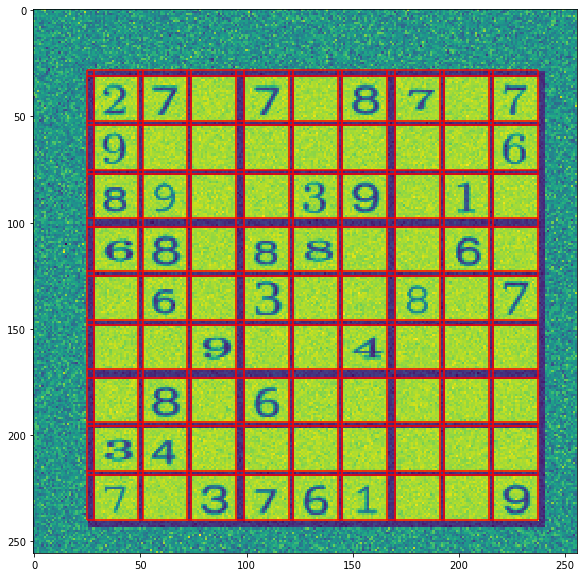

In [33]:
square_size = np.random.randint(16,22)
grid_thickness = np.random.randint(1,3)
square_grid_thickness = grid_thickness + np.random.randint(1,3)
grid_border_thickness = np.random.randint(1,6)
grid_alpha = 1
border_alpha = 0
noise = (0.0,0.05)
canvas_size_in = 256
canvas_size_out = 256
offcenter = (np.random.randint(-12,12),np.random.randint(-12,12))
canvas_noise = (0,0.1)
rotation = 0

sudoku_grid = create_sudoku_grid(square_size, grid_thickness, square_grid_thickness, grid_border_thickness, grid_alpha, border_alpha, noise,
                                (numbers,labels), filling_mode="numbers")
sudoku_img = create_training_image(sudoku_grid, canvas_size_in, (canvas_size_out,canvas_size_out), offcenter, canvas_noise, rotation)

# img_1D = np.reshape(sudoku_img, [1,sudoku_img.shape[0]*sudoku_img.shape[1]])

plt.figure(figsize=(10,10))
plt.imshow(sudoku_img)
signchange_indexv, signchange_indexh = square_coords(sudoku_img)
plt.hlines(signchange_indexv, xmax=max(signchange_indexh), xmin=min(signchange_indexh), color="red")
plt.vlines(signchange_indexh, ymax=max(signchange_indexv), ymin=min(signchange_indexv), color="red")
plt.show()

# x = 0
# y = 0
# fig = plt.figure(figsize=(10,10))
# axes = fig.subplots(9,9)
# for i in range(1,19,2):
#     for j in range(1,19,2):
#         subsquare = sudoku_img[signchange_indexv[i]+1:signchange_indexv[i+1],signchange_indexh[j]+1:signchange_indexh[j+1]]
#         axes[x,y].imshow(subsquare, vmin=0, vmax=1)
# #         print(x_train[k].reshape([256,256])[signchange_indexv[i]+1:signchange_indexv[i+1],signchange_indexh[j]+1:signchange_indexh[j+1]].shape)
#         axes[x,y].set_xticklabels(())
#         axes[x,y].set_yticklabels(())
#         y += 1
#     y = 0
#     x +=1
# plt.show()

In [551]:
f = open("data.txt", "a")

for k in range(500):
    square_size = np.random.randint(12,18)
    grid_thickness = np.random.randint(1,3)
    square_grid_thickness = grid_thickness + np.random.randint(1,3)
    grid_border_thickness = np.random.randint(1,6)
    grid_alpha = 1
    border_alpha = 1
    noise = (0.0,0.0)
    canvas_size_in = 200
    canvas_size_out = 256
    offcenter = (np.random.randint(-12,12),np.random.randint(-12,12))
    canvas_noise = (0,0.1)

    sudoku_grid = create_sudoku_grid(square_size, grid_thickness, square_grid_thickness, grid_border_thickness, grid_alpha, border_alpha, noise,
                                    x_train, filling_mode="numbers")
    sudoku_img = create_training_image(sudoku_grid, canvas_size_in, (canvas_size_out,canvas_size_out), offcenter, canvas_noise)

    a, b, c, d = find_sudoku_corners(square_size, grid_thickness, square_grid_thickness, grid_border_thickness, canvas_size_in, canvas_size_out, offcenter)

    img_1D = np.reshape(sudoku_img, [1,sudoku_img.shape[0]*sudoku_img.shape[1]])
    corners = np.array([a, b, c, d]).reshape([1,2*4])
    data = np.append(img_1D,corners)

    f.write(" ".join(np.array(data, dtype=str)))
    f.write("\n")

f.close()  

NameError: name 'x_train' is not defined

In [640]:
# testim = mpimg.imread("testimg.png")
# testim = cv2.resize(testim, (256,256), interpolation = cv2.INTER_AREA)
# testim = np.pad(testim[:,:,0], pad_width=2, constant_values=0)



In [3]:
def save_img(img, PATH, size=(28,28)):
    img_resized = cv2.resize(img, size, interpolation = cv2.INTER_AREA)
    np.savetxt(PATH, img_resized)
    
    
def permutate_img(img, translate_by, shrink_by, noise_params):
    # zoom / shrink
    if shrink_by > 0:
        img = np.pad(img, pad_width=shrink_by, constant_values=0)
    if shrink_by < 0:
        img = img[:shrink_by,:shrink_by]
    else:
        pass
    
    # translate
    M = np.float32([[1,0,translate_by[0]],[0,1,translate_by[1]]])
    img = cv2.warpAffine(img,M,img.shape)
    
    # add noise 
    noise = np.random.normal(noise_params[0], noise_params[1], img.shape)
    img = img+noise
    img = (img-np.min(img))/(np.max(img)-np.min(img))
    
    return img

def generate_trainingdata(imgs, labels, translation_range, shrinkage_range, noise_range, n_copies, size=(28,28)):
    for n in range(n_copies):
        rand_translation = np.random.randint(translation_range[0], translation_range[1],2)
        rand_shrinkage = np.random.randint(translation_range[0], translation_range[1])
        rand_noise = (noise_range[0] + noise_range[1]%np.random.random(1), noise_range[2] + noise_range[3]%np.random.random(1))
        for index, img in enumerate(imgs):
            permutated_img = permutate_img(img, rand_translation, rand_shrinkage, rand_noise)
            filename = "./numbers/x_" + str(labels[index]) + "_" + str(index) + "_" + str(n) + ".txt"
            save_img(permutated_img, filename, size)

In [478]:
generate_trainingdata(numbers, labels, (-2,2),(-2,2),(0.0,1.0,0.0,0.3),10)

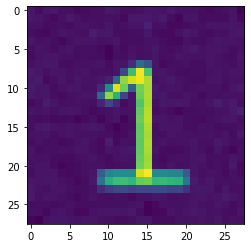

In [472]:
plt.imshow(np.loadtxt("./numbers/x_1_27_0.txt"))
plt.show()

In [13]:
numbers = mpimg.imread("numbers.png")

for i in range(9):
    save_img(numbers[:70,i*58:(i+1)*58,0], "./numbers/0_" + str(i+1)+".txt", (28,28))
    save_img(numbers[100:200,i*80:(i+1)*80-10,0], "./numbers/1_" + str(i+1)+".txt", (28,28))
    save_img(numbers[250:340,i*62:(i+1)*62,0], "./numbers/2_" + str(i+1)+".txt", (28,28))
    save_img(numbers[335:410,i*85:(i+1)*85-25,0], "./numbers/3_" + str(i+1)+".txt", (28,28))
    save_img(numbers[430:510,i*66:(i+1)*66,0], "./numbers/4_" + str(i+1)+".txt", (28,28))
    save_img(numbers[530:620,i*68:(i+1)*68,0], "./numbers/5_" + str(i+1)+".txt", (28,28))
    save_img(numbers[640:760,i*64:(i+1)*64-5,0], "./numbers/6_" + str(i+1)+".txt", (28,28))
    save_img(numbers[750:,i*85:(i+1)*85-25,0], "./numbers/7_" + str(i+1)+".txt", (28,28))
for k in range(8):
    np.savetxt("./numbers/" + str(k) + "_0" +".txt", np.ones([28,28]))

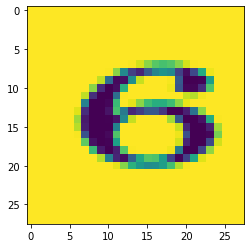

In [14]:
numbers = []
labels = []
for file in os.listdir("./numbers/"):
    numbers.append(np.loadtxt("./numbers/" + file))
    labels.append(int(file[-5:-4]))
numbers = np.array(numbers)

plt.imshow(numbers[0])
# plt.title("label = " + str(labels[8]))
plt.show()

In [4]:
# generate data for training

# sudoku = Sudoku()

# num_datapoints = 500
# # data = {"X" : [], "y": []}
# for k in range(139,num_datapoints):
#     sudoku.download_new()
#     canvas_size = 400
#     scale = 29
#     background_size = scale*9+1
#     center = int(canvas_size/2)*np.ones(2, dtype = "int")-int(background_size/2)*np.ones(2, dtype = "int")
#     board_position = (random.randint(-40,40), random.randint(-40,40)) # relative to the center
#     canvas_noise_params = (random.random(),random.random())
#     square_noise_params = (random.random()*0.3, random.random()*0.5)
#     pts = 1

#     canvas = np.random.normal(canvas_noise_params[0], canvas_noise_params[1], [canvas_size,canvas_size])
#     canvas[canvas < 0] = 0
#     canvas[canvas > 1] = 1
#     background = np.zeros([background_size, background_size])
#     grid = np.zeros(background.shape)
#     squares = np.zeros(background.shape)
#     square_len = int((background_size+8)/9)

#     for i in range(9):
#         for j in range(9):
#             grid[square_len*(i)-1*i:square_len*(i+1)-1*i,square_len*(j)-1*j:square_len*(j+1)-1*j] = np.pad(np.zeros([square_len-2*pts,square_len-2*pts]),pts, mode="constant", constant_values=1)
#             number = sudoku.current_state[i,j]
#             square_content = x_train[y_train[:] == number][random.randint(0,len(x_train[y_train[:] == number])-1)]
#             noise = np.random.normal(square_noise_params[0], square_noise_params[1], square_content[square_content == 0].shape[0])
#             noise[noise < 0] = 0
#             noise[noise > 1] = 1
#             square_content[square_content == 0] = square_content[square_content == 0] + noise
#             squares[square_len*(i)-1*i:square_len*(i+1)-1*i, square_len*(j)-1*j:square_len*(j+1)-1*j] = np.pad(square_content, pts, mode="constant", constant_values=0)
#     board = background + grid + squares

#     centered_position = center + board_position
#     canvas[centered_position[0]:centered_position[0] + board.shape[0], centered_position[1]:centered_position[1] + board.shape[1]] = board
# #     plt.figure(figsize=(10,10))
# #     plt.imshow(canvas, cmap = "Greys")
# #     data["X"].append(canvas)
# #     data["y"].append(sudoku.current_state)
#     print("generated datapoint " + str(k+1) + "/" + str(num_datapoints))
#     np.savetxt("data/X_"+str(k)+".txt", canvas,fmt='%1.2f')
#     np.savetxt("data/y_"+str(k)+".txt", sudoku.current_state,fmt='%1.0f')
# #     plt.show()